In [1]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow-addons==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

In [2]:
import tensorflow

In [3]:
tensorflow.__version__

'2.8.0'

## STEP 1 : Loading Dataset

In [4]:
# import Libs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [5]:
# import dataset
num_classes = 10
input_shape = (32,32,3)

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [6]:
X_train.shape

(50000, 32, 32, 3)

In [7]:
y_train.shape

(50000, 1)

In [8]:
X_test.shape

(10000, 32, 32, 3)

In [9]:
y_test.shape

(10000, 1)

## STEP 2: Hyperparameter Definition

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 72 # we'll resize the input image to this size
patch_size = 6 # Size of the patches ro be extracted from the input image
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim] # size of transformer layer
transformer_layers = 8
mlp_head_units = [2048, 1024] # size of dense layer of final classifier

## STEP 3: Build ViT Classifier Model

3.1 Data Augmetation

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="data_augmentation",)
data_augmentation.layers[0].adapt(X_train)

3.2 Define MLP Architecture

In [12]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation= tf.nn.gelu)(x) # gaussuan error linear unit
    x = layers.Dropout(dropout_rate)(x)
  return x

3.3 Patches

In [13]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches,self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images, sizes = [1, self.patch_size, self.patch_size, 1],
                                       strides = [1, self.patch_size, self.patch_size, 1], rates = [1,1,1,1],
                                       padding = 'VALID')
    patch_dim = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dim])
    return patches

Image size: 72 x 72
Patch size: 6 X 6
Patches per image: (patches.shape[1])
Elements per patch: (patches.shape[-1]


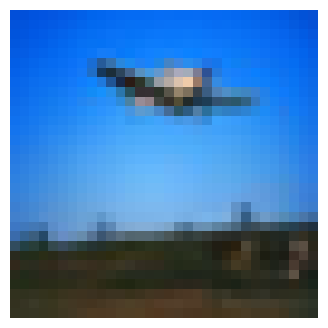

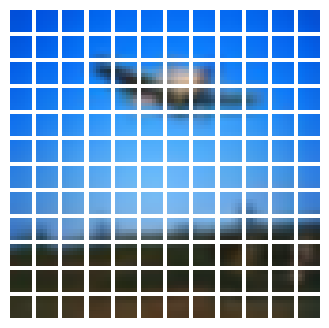

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)

print(f"Image size: {image_size} x {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: (patches.shape[1])")
print(f"Elements per patch: (patches.shape[-1]")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n,n,i+1)
  patch_imag = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_imag.numpy().astype('uint8'))
  plt.axis('off')

In [15]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded


In [16]:
def create_vit_classifier():
  inputs = layers.Input(shape = input_shape)
  # Agument Data
  augmentation = data_augmentation(inputs)
  # Create Patches
  patches = Patches(patch_size)(augmentation)
  # Encode Patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the transformer block
  for _ in range(transformer_layers):
    # Layer Normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create Multi-head Attension layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim = projection_dim, dropout=0.1)(x1,x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])
    # Layer Normalization 2
    x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
    # mlp
    x4 = mlp(x3, hidden_units = transformer_units, dropout_rate=0.1)
    # skip connection 2.
    encoded_patches = layers.Add()([x4, x2])

  # Create a [batch_size, projection_dim] tensor
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5) (representation)

  # Add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  # Classify outputs
  logits = layers.Dense(num_classes)(features)

  # create keras model
  model = keras.Model(inputs=inputs, outputs=logits)
  return model

In [17]:
def run(model):
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay= weight_decay)

  model.compile(optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [
                    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                    keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy"),
                    ],
                )

  checkpoint_filepath = "./tmp/checkpoint"

  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True
      )

  history = model.fit(x=X_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=num_epochs,
                      validation_split=0.1,
                      callbacks=[checkpoint_callback],)

  _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
  print(f"Test Accuracy: {round(accuracy *100), 2}%")
  print(f"Test top 5 Accuracy: {round(top_5_accuracy *100), 2}%")

In [18]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)

Epoch 1/30
176/176 [==============================] - 81s 382ms/step - loss: 2.0913 - accuracy: 0.3102 - top_5_accuracy: 0.8025 - val_loss: 1.5456 - val_accuracy: 0.4510 - val_top_5_accuracy: 0.9086
Epoch 2/30
176/176 [==============================] - 67s 381ms/step - loss: 1.5579 - accuracy: 0.4357 - top_5_accuracy: 0.8988 - val_loss: 1.3343 - val_accuracy: 0.5202 - val_top_5_accuracy: 0.9366
Epoch 3/30
176/176 [==============================] - 74s 419ms/step - loss: 1.3949 - accuracy: 0.5012 - top_5_accuracy: 0.9256 - val_loss: 1.2523 - val_accuracy: 0.5736 - val_top_5_accuracy: 0.9444
Epoch 4/30
176/176 [==============================] - 75s 427ms/step - loss: 1.2904 - accuracy: 0.5398 - top_5_accuracy: 0.9380 - val_loss: 1.1015 - val_accuracy: 0.6144 - val_top_5_accuracy: 0.9602
Epoch 5/30
176/176 [==============================] - 70s 400ms/step - loss: 1.2123 - accuracy: 0.5702 - top_5_accuracy: 0.9466 - val_loss: 1.0429 - val_accuracy: 0.6264 - val_top_5_accuracy: 0.9674
Epoch

In [19]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [20]:
def img_predict(images, model):
  if len(images.shape) == 3:
    out = model.predict(images.reshape(-1, *images.shape))
  else:
    out = model.predict(images)
  prediction= np.argmax(out, axis = 1)
  img_prediction = [class_names[i] for i in prediction]

  return img_prediction

['frog']


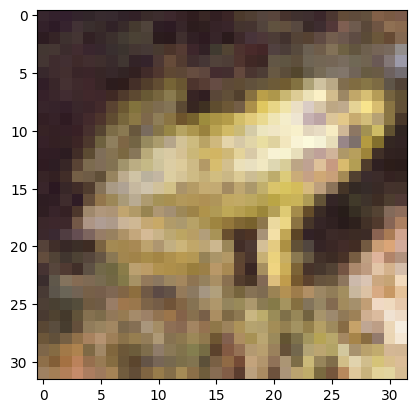

In [22]:
index = 19
plt.imshow(X_test[index])
prediction = img_predict(X_test[index], vit_classifier)
print(prediction)